# Getting PSF information from CSC2.0


The CSC simulates the PSF for each detection in each obsid it is imaged in.  Even low count sources and sources not detected in the detect stack have a simulated PSF.  This is done for each of the energy bands.  I'm not sure of the exact details of how the PSFs are generated (number of rays, bin size, etc).

Then for each PSF the ellipse centered at the detect location that enclosed ~90% of the PSF is computed (using `dmellipse`).  These values are stored in there per-obi table as the `mjr_axis_aper90_{band}`, `mnr_axis_aper90_{band}`, and `pos_angle_aper90_{band}` values.

Since the PSF is simulated and the aper90 region is computed for **all** detections, even faint sources, this gives rise to over 1.4 million estimates of the aper90 region randomly fairly randomly distributed across the detectors (with a bias to on-axis sources).

The goal of this work is to reduce this into a CALDB-like data product that could be used to look up the PSF90 region at an arbitrary location and use that region with for example `srcflux` as an improvement over the 
circular regions it uses by default.

## Search CSC 2.0

We start by getting the per-obi PSF size information for each energy band, for all _detections_.

We converted this from `.tsv` to `.fits` with `dmcopy` and get

In [1]:
dmlist csc_w_sim_and_roll.fits counts

1420545 


In [2]:
dmlist csc_w_sim_and_roll.fits cols

 

⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼

Columns for Table Block cscresults.3.tsv

⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼

 
ColNo  Name                 Unit        Type             Range
   1   obs_id                            Int4           -                    Observation identifier
   2   obi                               Int4           -                    Observation interval number
   3   region_id                         Int4           -                    Detection region identifier (component number)
   4   theta                arcmin       Real4          -Inf:+Inf            PSF 90% ECF aperture off-axis angle
   5   phi                  deg          Real4          -Inf:+Inf            PSF 90% ECF aperture azimuthal angle
   6   mjr_axis_aper90_b    arcsec       Real4          -Inf:+Inf            Semi-major axis of the elliptical PSF 90% ECF a
   7   mnr_axis_aper90_b    arcsec       Real

## New coordinate system: `NOT_DET`

To make things easier to visualize we create a new coordinate system we will call `NOT_DET`.  It is like `DET` coordinates, but not exactly since it is in units of arcmin rather than pixels.  It is based on the off-axis angles $\theta$ and $\phi$

$$
x = \theta * \cos(\phi) \\
y = \theta * \sin(\phi)
$$


The position angle values, `pos_angle_aper90_*`, are measured in sky coordinates.  To convert them into our `NOT_DET` coordinate system we need to rotate them by the `ROLL_PNT` for the observation.

$$
\omega = ( \alpha + \mathrm{ROLL\_PNT} ) \bmod 180.0
$$

>  It is not certain if this is 100% accurate.  `ROLL_PNT` is technically only accurate at the tangent point.
>  We are unsure if the position angle values are being adjusted just for ROLL_PNT or if they are 
>  adjusted for their location with the FOV.

We will add these as new columns in the table

In [3]:
cat << EOM > e.lis
.phideg=phi*#pi/180.0
not_detx=theta*cos(.phideg)
not_dety=theta*sin(.phideg)
droll_b=((pos_angle_aper90_b+roll_pnt)%180)
droll_s=((pos_angle_aper90_s+roll_pnt)%180)
droll_m=((pos_angle_aper90_m+roll_pnt)%180)
droll_h=((pos_angle_aper90_h+roll_pnt)%180)
droll_u=((pos_angle_aper90_u+roll_pnt)%180)
droll_w=((pos_angle_aper90_w+roll_pnt)%180)
EOM

infile=csc_w_sim_and_de_roll.fits

dmtcalc "csc_w_sim_and_roll.fits" $infile exp=@e.lis clob+

## Quick look

It will help to get a quick look at the data in the new coordinate system.  Below we plot the color-coded major axis length in our not_detx, not_dety coordinate system.

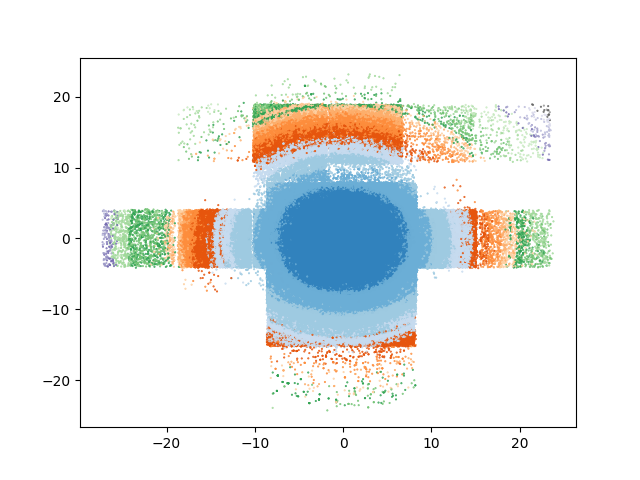

In [4]:
python << EOM
import matplotlib.pylab as plt
from pycrates import read_file

tab = read_file("csc_w_sim_and_de_roll.fits")
xx = tab.get_column("not_detx").values
yy = tab.get_column("not_dety").values
zz = tab.get_column("mjr_axis_aper90_m").values

plt.scatter(xx,yy, c=zz, cmap='tab20c', marker=".", s=1)
plt.savefig("ql1.png")
EOM

display < ql1.png


This plot should look familar.  We are seeing the ACIS-I and ACIS-S arrays as they overlap in the NOT_DET coordinate system.  The PSF size increases with off-axis angle which gives rise to the radial pattern we are seeing.

We can restrict this to just ACIS-I by filtering on `SIM_Z`

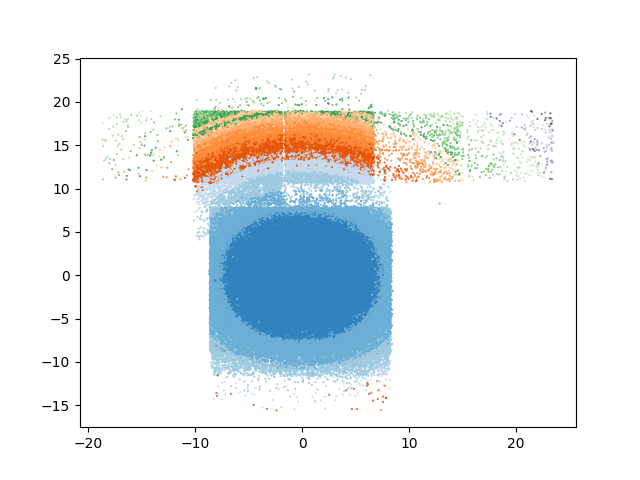

In [5]:
python << EOM
import matplotlib.pylab as plt
from pycrates import read_file

tab = read_file("csc_w_sim_and_de_roll.fits")
xx = tab.get_column("not_detx").values
yy = tab.get_column("not_dety").values
zz = tab.get_column("mjr_axis_aper90_m").values
sim = tab.get_column("sim_z").values

idx = sim<-210

plt.scatter(xx[idx],yy[idx], c=zz[idx], cmap='tab20c', marker=".", s=1)
plt.savefig("ql2.png")
EOM

display < ql2.png


Now we are just seeing the data when the aimpoint was on ACIS-I.  The ACIS-6 and ACIS-7 have the most sources in this configuration, but there are some observations done at the ACIS-I aimpoint with ACIS-5, -8, and even -9.

The gap between the -I and -S array is not entirely devoid of sources because there are some observations with (large) SIM_Z offsets. 

In these two plots we do not see the HRC data because of the energy band.  To see the HRC data we need to use the `w`, wide band values


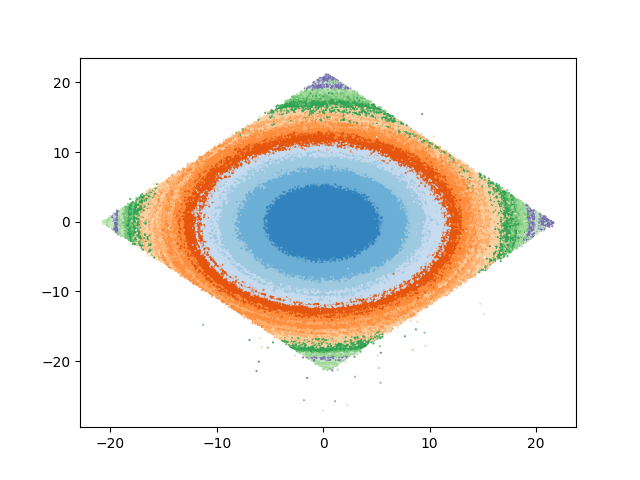

In [6]:
python << EOM
import matplotlib.pylab as plt
from pycrates import read_file

tab = read_file("csc_w_sim_and_de_roll.fits")
xx = tab.get_column("not_detx").values
yy = tab.get_column("not_dety").values
zz = tab.get_column("mjr_axis_aper90_w").values

plt.scatter(xx,yy, c=zz, cmap='tab20c', marker=".", s=1)
plt.savefig("ql3.png")
EOM

display < ql3.png


## Get median value

The tables are nice, but randomly sampled and noisy (point-to-point).  Instead what we want is some kind of "smoothed" version on a nice regular grid.

To do this we use some of the tools from the (TBR) adaptive binning tools suite to create a regular, rectangular grid and then to compute the _median_ value at each grid location.


### Make the grid with `mkregmap`

To start we use `mkregmap` to create a map image which groups pixels together based on a stack of input region.  In this case, our input stack is an `rgrid()` to create a rectangular grid.  We choose to use a grid size of 0.5 arcmin to keep the size of the output reasonable and provide enough data points in most of the bins to make the median meaningful.


In [7]:
bin="not_detx=-30:30:0.05,not_dety=-30:30:0.05"

mkregmap "${infile}[bin $bin]" 'rgrid(-30:30:0.5,-30:30:0.5)' sqr.grid mode=h clob+ coord=not_detx 
mapfile=sqr.grid

mkregmap
          infile = csc_w_sim_and_de_roll.fits[bin not_detx=-30:30:0.05,not_dety=-30:30:0.05]
         regions = rgrid(-30:30:0.5,-30:30:0.5)
         outfile = sqr.grid
          binimg = 
           coord = not_detx
         clobber = yes
         verbose = 1
            mode = h



####  `SIM_Z` : Detector definition

We see differences in the PSF size on ACIS-I vs ACIS-S data due to the detector geometry (tilted chips).  We therefore want to separate the input table into 3 parts:  ACIS-I, ACIS-S, and HRC (HRC-I).  There are no CSC data for HRC-S.  We define

| Detector | SIM_Z             |
|----------|-------------------|
| ACIS-I   |   sim_z < -210    |
| ACIS-S   | -210 <= sim_z < 0 |
| HRC      | sim_z > 0         |

### Energy Band

We choose to look at the `m` (medium) energy band since is uses a 1.5keV monochromatic energy to simulate the PSF. This most closely matches the `srcflux` and `acis_extract` energies.

### Compute the median with `statmap`

The `statmap` script computes the requested statistic for all the rows from the input table for each grid in the input map file.  

In [9]:
band="m"
filter="sim_z<-210,mjr_axis_aper90_${band}>0"
detector="acis_i"

statmap "${infile}[${filter}]" ${mapfile} col=mjr_axis_aper90_${band} \
    out=${detector}_median_mjr_axis_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+


statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z<-210,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_i_median_mjr_axis_aper90_m.img
          column = mjr_axis_aper90_m
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql



#### Custom color map

We choose to use a custom color map similar to the matplotlib color map shown earlier

In [10]:
wget http://soliton.vm.bytemark.co.uk/pub/cpt-city/ncl/StepSeq25.sao

--2022-07-21 08:07:28--  http://soliton.vm.bytemark.co.uk/pub/cpt-city/ncl/StepSeq25.sao
Resolving soliton.vm.bytemark.co.uk (soliton.vm.bytemark.co.uk)... 89.16.175.95
Connecting to soliton.vm.bytemark.co.uk (soliton.vm.bytemark.co.uk)|89.16.175.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2052 (2.0K) [text/x-cmap-sao]
Saving to: ‘StepSeq25.sao’

StepSeq25.sao       100%[===================>]   2.00K  --.-KB/s    in 0s      

2022-07-21 08:07:29 (78.5 MB/s) - ‘StepSeq25.sao’ saved [2052/2052]



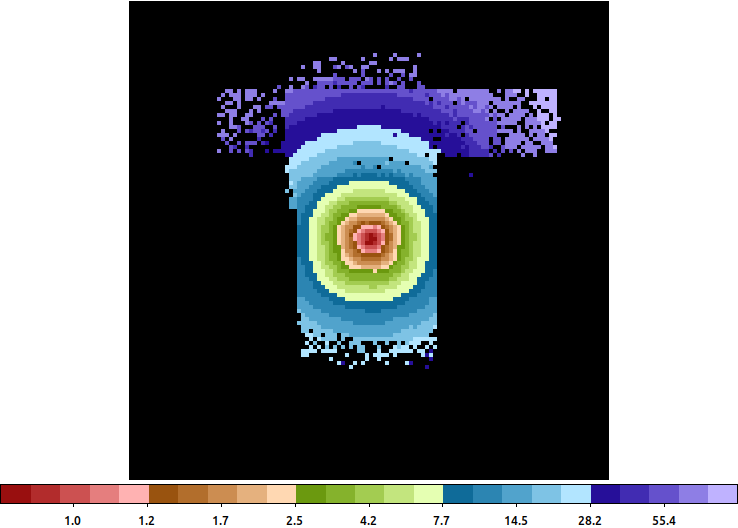

In [11]:
ds9 ${detector}_median_mjr_axis_aper90_${band}.img -scale log -cmap load StepSeq25.sao \
  -zoom to fit -saveimage png ${detector}_median_mjr_axis_aper90_${band}.png \
  -exit

display < ${detector}_median_mjr_axis_aper90_${band}.png

This is similar to images above for ACIS-I.  But now each grid has the median `mjr_axis_aper90_m` value at that location.

Just for sanity, we check how many values (ie rows) are being used to compute the median.  

In [12]:
statmap "${infile}[${filter}]" ${mapfile} col=mjr_axis_aper90_${band} out=${detector}.cts \
    stat=count xcol=not_detx ycol=not_dety clob+


statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z<-210,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_i.cts
          column = mjr_axis_aper90_m
       statistic = count
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql



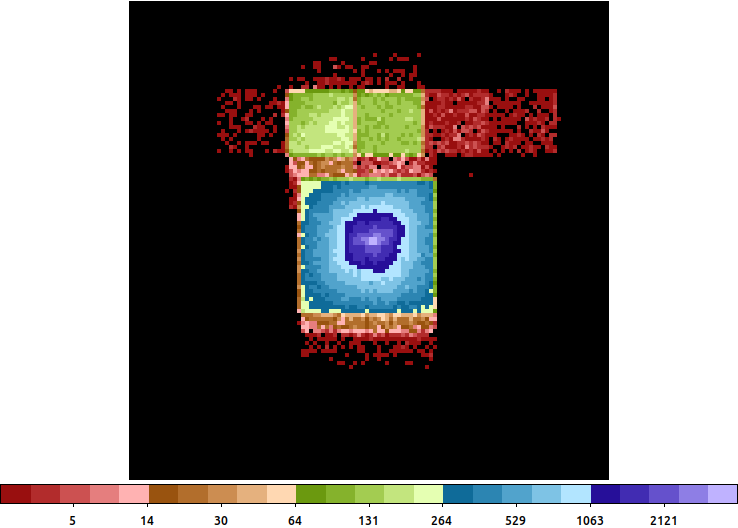

In [13]:
ds9 ${detector}.cts -scale log -cmap load StepSeq25.sao \
  -zoom to fit -saveimage png ${detector}.png \
  -exit

display < ${detector}.png

As we'd expect there are a large number of detections near the ACIS-I aimpoint (generally over 1000) with far fewer detections on the outer chips and with non-standard SIM_Z offsets (gap between the chips).

We then repeat this for the minor axis

statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z<-210,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_i_median_mnr_axis_aper90_m.img
          column = mnr_axis_aper90_m
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql



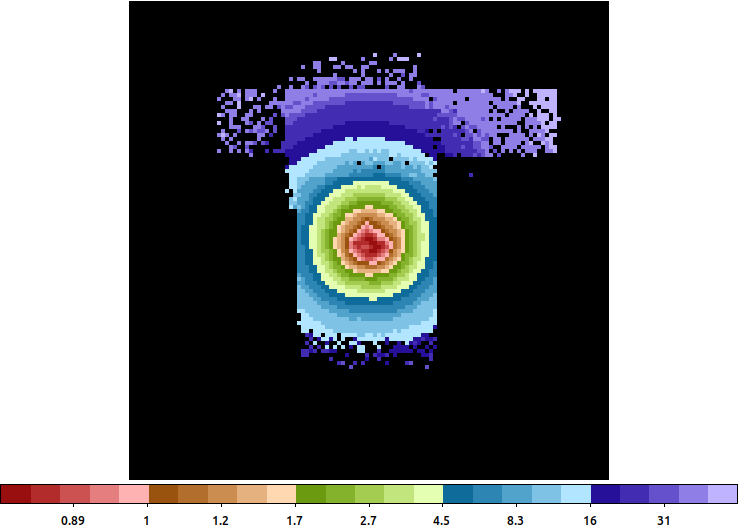

In [14]:
statmap "${infile}[${filter}]" ${mapfile} col=mnr_axis_aper90_${band} \
  out=${detector}_median_mnr_axis_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+

froot=${detector}_median_mnr_axis_aper90_${band}

ds9 ${froot}.img -scale log -cmap load StepSeq25.sao \
  -zoom to fit -saveimage png ${froot}.png \
  -exit

display < ${froot}.png


and for the roll_pnt corrected position angle:

statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z<-210,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_i_median_angle_aper90_m.img
          column = droll_m
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql



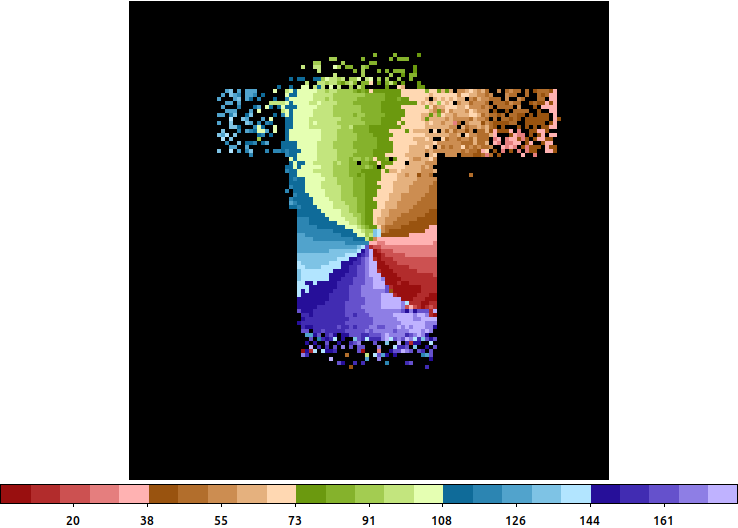

In [15]:
statmap "${infile}[${filter}]" ${mapfile} col=droll_${band} \
  out=${detector}_median_angle_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+

froot=${detector}_median_angle_aper90_${band}

ds9 ${froot}.img -scale linear -cmap load StepSeq25.sao \
  -zoom to fit -saveimage png ${froot}.png \
  -exit

display < ${froot}.png


It's a little hard to see here, but right at the aimpoint the position angle values become very random.  This is because the PSF is nearly circular and thus the angle becomes unconstrained.

## Repeat for ACIS-S

In [16]:
band="m"
filter="sim_z=-210:0,mjr_axis_aper90_${band}>0"
detector="acis_s"

statmap "${infile}[${filter}]" ${mapfile} col=mjr_axis_aper90_${band} \
  out=${detector}_median_mjr_axis_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+
statmap "${infile}[${filter}]" ${mapfile} col=mnr_axis_aper90_${band} \
  out=${detector}_median_mnr_axis_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+
statmap "${infile}[${filter}]" ${mapfile} col=droll_${band} \
  out=${detector}_median_angle_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+
statmap "${infile}[${filter}]" ${mapfile} col=mjr_axis_aper90_${band} \
  out=${detector}.cts stat=count xcol=not_detx ycol=not_dety clob+


statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z=-210:0,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_s_median_mjr_axis_aper90_m.img
          column = mjr_axis_aper90_m
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql

statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z=-210:0,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_s_median_mnr_axis_aper90_m.img
          column = mnr_axis_aper90_m
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql

statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z=-210:0,mjr_axis_aper90_m>0]
         mapfile = sqr.grid
         outfile = acis_s_median_angle_aper90_m.img
          column = droll_m
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         

## Repeat for HRC

In [17]:
band="w"
filter="sim_z=0:,mjr_axis_aper90_${band}>0"
detector="hrc"
statmap "${infile}[${filter}]" ${mapfile} col=mjr_axis_aper90_${band} \
  out=${detector}_median_mjr_axis_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+
statmap "${infile}[${filter}]" ${mapfile} col=mnr_axis_aper90_${band} \
  out=${detector}_median_mnr_axis_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+
statmap "${infile}[${filter}]" ${mapfile} col=droll_${band} \
  out=${detector}_median_angle_aper90_${band}.img stat=median xcol=not_detx ycol=not_dety clob+
statmap "${infile}[${filter}]" ${mapfile} col=mjr_axis_aper90_${band} \
  out=${detector}.cts stat=count xcol=not_detx ycol=not_dety clob+ 


statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z=0:,mjr_axis_aper90_w>0]
         mapfile = sqr.grid
         outfile = hrc_median_mjr_axis_aper90_w.img
          column = mjr_axis_aper90_w
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql

statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z=0:,mjr_axis_aper90_w>0]
         mapfile = sqr.grid
         outfile = hrc_median_mnr_axis_aper90_w.img
          column = mnr_axis_aper90_w
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
         verbose = 1
            mode = ql

statmap
          infile = csc_w_sim_and_de_roll.fits[sim_z=0:,mjr_axis_aper90_w>0]
         mapfile = sqr.grid
         outfile = hrc_median_angle_aper90_w.img
          column = droll_w
       statistic = median
         xcolumn = not_detx
         ycolumn = not_dety
         clobber = yes
       

You can find all these files in

**`/data/lenin2/Projects/PSF90`**

## Next steps

We will want to package these individual files into a multi-HDU file, one for each detector (basically just `dmappend` with some `dmhedit` to add meta-data).

We can then create a script akin to `psfsize_srcs` that takes in one of these files, a list of coordinates, and outputs the 90% ellipse.  We can do this either by taking the closest location in the NOT_DET coordinate system or by a weighted average (probably some incarnation of `dmimgpick`).  Obviously we are fixed at 90% but we could also make these products for the other energy bands.

These ellipses will then be run through `roi` and feed into `srcflux` to compare against the default circle regions.


## Package

In [18]:
detector="acis_i"
band="m"

dmimgcalc ${detector}_median_mjr_axis_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none ${detector}_psf90.fits"[MAJOR_AXIS]"  op="imgout=(img1/100.0)" clob+

dmimgcalc ${detector}_median_mnr_axis_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none tmp"[MINOR_AXIS]" op="imgout=(img1/100.0)" clob+
dmappend tmp ${detector}_psf90.fits

dmimgcalc ${detector}_median_angle_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none tmp"[ANGLE]" op="imgout=(img1/100.0)" clob+
dmappend tmp ${detector}_psf90.fits

/bin/rm tmp


In [19]:
# TODO: add energy range , mono energy

cat << EOM > hdr.dat
#add
BUNIT = "arcsec" /  Units of pixel value
CUNIT1P = "arcmin" / Units of NOT_DETX coordinate
CUNIT2P = "arcmin" / Units of NOT_DETX coordinate
SIM_Z_LO = -1000 / [mm] Range of SIM-Z minimum
SIM_Z_HI = -210 / [mm] Range of SIM-Z maximum
EOM

dmhedit  ${detector}_psf90.fits"[MAJOR_AXIS]" file=hdr.dat 
dmhedit  ${detector}_psf90.fits"[MINOR_AXIS]" file=hdr.dat 

cat << EOM > hdr.dat
#add
BUNIT = "deg" /  Units of pixel value
CUNIT1P = "arcmin" / Units of NOT_DETX coordinate
CUNIT2P = "arcmin" / Units of NOT_DETX coordinate
SIM_Z_LO = -1000 / [mm] Range of SIM-Z minimum
SIM_Z_HI = -210 / [mm] Range of SIM-Z maximum
EOM

dmhedit  ${detector}_psf90.fits"[ANGLE]" file=hdr.dat 


In [20]:
detector="acis_s"
band="m"

dmimgcalc ${detector}_median_mjr_axis_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none ${detector}_psf90.fits"[MAJOR_AXIS]"  op="imgout=(img1/100.0)" clob+

dmimgcalc ${detector}_median_mnr_axis_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none tmp"[MINOR_AXIS]" op="imgout=(img1/100.0)" clob+
dmappend tmp ${detector}_psf90.fits

dmimgcalc ${detector}_median_angle_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none tmp"[ANGLE]" op="imgout=(img1/100.0)" clob+
dmappend tmp ${detector}_psf90.fits

/bin/rm tmp


In [21]:
cat << EOM > hdr.dat
#add
BUNIT = "arcsec" /  Units of pixel value
CUNIT1P = "arcmin" / Units of NOT_DETX coordinate
CUNIT2P = "arcmin" / Units of NOT_DETX coordinate
SIM_Z_LO = -210 / [mm] Range of SIM-Z minimum
SIM_Z_HI = 0 / [mm] Range of SIM-Z maximum
EOM

dmhedit  ${detector}_psf90.fits"[MAJOR_AXIS]" file=hdr.dat 
dmhedit  ${detector}_psf90.fits"[MINOR_AXIS]" file=hdr.dat 

cat << EOM > hdr.dat
#add
BUNIT = "deg" /  Units of pixel value
CUNIT1P = "arcmin" / Units of NOT_DETX coordinate
CUNIT2P = "arcmin" / Units of NOT_DETX coordinate
SIM_Z_LO = -210 / [mm] Range of SIM-Z minimum
SIM_Z_HI = 0 / [mm] Range of SIM-Z maximum
EOM

dmhedit  ${detector}_psf90.fits"[ANGLE]" file=hdr.dat 


In [22]:
detector="hrc"
band="w"

dmimgcalc ${detector}_median_mjr_axis_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none ${detector}_psf90.fits"[MAJOR_AXIS]"  op="imgout=(img1/100.0)" clob+

dmimgcalc ${detector}_median_mnr_axis_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none tmp"[MINOR_AXIS]" op="imgout=(img1/100.0)" clob+
dmappend tmp ${detector}_psf90.fits

dmimgcalc ${detector}_median_angle_aper90_${band}.img"[bin #1=::10,#2=::10]" \
  none tmp"[ANGLE]" op="imgout=(img1/100.0)" clob+
dmappend tmp ${detector}_psf90.fits

/bin/rm tmp


In [23]:
cat << EOM > hdr.dat
#add
BUNIT = "arcsec" /  Units of pixel value
CUNIT1P = "arcmin" / Units of NOT_DETX coordinate
CUNIT2P = "arcmin" / Units of NOT_DETX coordinate
SIM_Z_LO = 0 / [mm] Range of SIM-Z minimum
SIM_Z_HI = 1000 / [mm] Range of SIM-Z maximum
EOM

dmhedit  ${detector}_psf90.fits"[MAJOR_AXIS]" file=hdr.dat 
dmhedit  ${detector}_psf90.fits"[MINOR_AXIS]" file=hdr.dat 

cat << EOM > hdr.dat
#add
BUNIT = "deg" /  Units of pixel value
CUNIT1P = "arcmin" / Units of NOT_DETX coordinate
CUNIT2P = "arcmin" / Units of NOT_DETX coordinate
SIM_Z_LO = 0 / [mm] Range of SIM-Z minimum
SIM_Z_HI = 1000 / [mm] Range of SIM-Z maximum
EOM

dmhedit  ${detector}_psf90.fits"[ANGLE]" file=hdr.dat 
